In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score,recall_score,precision_score
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import TrainingArguments
from accelerate.state import AcceleratorState, PartialState
from transformers import AutoModel, AutoTokenizer, Trainer, TrainingArguments, AutoModelForSequenceClassification
from transformers.data.processors.utils import InputFeatures
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, pipeline

In [32]:
train_df = pd.read_csv("./datasets/training_set_20231217.csv")
val_df = pd.read_csv("./datasets/validation_set_20231217.csv")
test_df = pd.read_csv("./datasets/testing_set_20231217.csv")

In [33]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(160000, 3)
(20000, 3)
(20000, 3)


In [4]:
model_name = "distilbert-base-uncased"
model = AutoModel.from_pretrained(model_name)
model.eval()
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [5]:
device = torch.device('cuda')
model = model.to(device)

<Axes: xlabel='emotion'>

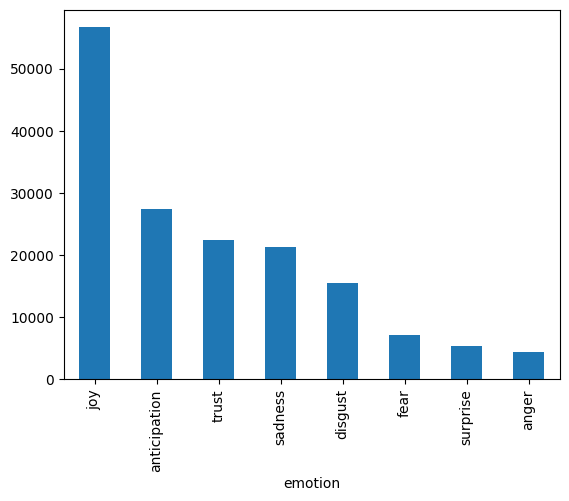

In [34]:
labels = train_df["emotion"].unique()
train_df["emotion"].value_counts().plot(kind="bar")

In [7]:
class CustomDataset:
    def __init__(
        self,
        name: str,
        train:pd.DataFrame,
        test: pd.DataFrame,
        label_list: list,
    ):
        self.name = name
        self.train = train
        self.test = test
        self.label_list = label_list

In [8]:
dataset = CustomDataset("emotion", train_df, test_df, labels)
# list(dataset.train["text"][0:10])

In [10]:
class ClassificationDataset(Dataset):
    def __init__(self, text, target, model_name, max_len, label_map):
        super(ClassificationDataset).__init__()

        self.text = text
        self.target = target
        self.tokenizer_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.max_len = max_len
        self.label_map = label_map

    def __len__(self):
        return len(self.text)

    def __getitem__(self,item):
        text = str(self.text[item])
        text = " ".join(text.split())

        inputs = self.tokenizer(
          text,
          max_length=self.max_len,
          padding='max_length',
          truncation=True
        )      
        return InputFeatures(**inputs,label=self.label_map[self.target[item]])

In [11]:
label_map = { v:index for index, v in enumerate(dataset.label_list) }
max_len = 64
print(label_map)

train_dataset = ClassificationDataset(
    dataset.train["text"].to_list(),
    dataset.train["emotion"].to_list(),
    model_name,
    max_len,
    label_map
  )
test_dataset = ClassificationDataset(
    dataset.test["text"].to_list(),
    dataset.test["emotion"].to_list(),
    model_name,
    max_len,
    label_map
  )

{'sadness': 0, 'trust': 1, 'anticipation': 2, 'joy': 3, 'surprise': 4, 'anger': 5, 'disgust': 6, 'fear': 7}


In [12]:
# print(next(iter(train_dataset)))

InputFeatures(input_ids=[101, 3909, 2188, 2007, 2019, 26668, 3493, 6865, 7840, 100, 4067, 2017, 5772, 999, 1026, 1048, 2232, 1028, 1026, 1048, 2232, 1028, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], token_type_ids=None, label=0)


In [13]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, return_dict=True, num_labels=len(label_map))

In [14]:
def compute_metrics(p): 
    preds = np.argmax(p.predictions, axis=1)
    assert len(preds) == len(p.label_ids)
    
    macro_f1 = f1_score(p.label_ids,preds,average='macro')
    acc = accuracy_score(p.label_ids,preds)
    
    return {       
        'macro_f1' : macro_f1,
        'accuracy': acc
    }

In [15]:
training_args = TrainingArguments( 
    output_dir= "./train",    
    adam_epsilon = 1e-8,
    learning_rate = 2e-5,
    fp16 = False, # enable this when using V100 or T4 GPU
    per_device_train_batch_size = 8, # up to 64 on 16GB with max len of 128
    per_device_eval_batch_size = 8,
    gradient_accumulation_steps = 4, # use this to scale batch size without needing more memory
    num_train_epochs= 10,
    warmup_ratio = 0,
    do_eval = True,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True, # this allows to automatically get the best model at the end based on whatever metric we want
    metric_for_best_model = 'macro_f1',
    greater_is_better = True,
    seed = 25
  )

In [16]:
trainer = Trainer(
    model = model_init(),
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy
1,1.418900,1.368329,0.495491,0.492750
2,1.232900,1.324460,0.513259,0.512750
3,1.057100,1.369539,0.523395,0.522750
4,0.877800,1.459738,0.508068,0.512750
5,0.727500,1.589891,0.510103,0.513000
6,0.568500,1.747370,0.509831,0.510000
7,0.447200,1.922953,0.505226,0.505750
8,0.365400,2.074462,0.503074,0.503000
9,0.301200,2.188653,0.505401,0.505250
10,0.259700,2.235768,0.504706,0.505250


Checkpoint destination directory ./train\checkpoint-4500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


TrainOutput(global_step=22500, training_loss=0.7363632517496744, metrics={'train_runtime': 77597.3027, 'train_samples_per_second': 9.279, 'train_steps_per_second': 0.29, 'total_flos': 1.192334155776e+16, 'train_loss': 0.7363632517496744, 'epoch': 10.0})

In [17]:
trainer.evaluate()

{'eval_loss': 1.3695387840270996,
 'eval_macro_f1': 0.5233953620833803,
 'eval_accuracy': 0.52275,
 'eval_runtime': 66.0144,
 'eval_samples_per_second': 60.593,
 'eval_steps_per_second': 7.574,
 'epoch': 10.0}

In [18]:
inv_label_map = { v:k for k, v in label_map.items()}
print(inv_label_map)

# Assign the label mappings to the model configuration
trainer.model.config.label2id = label_map
trainer.model.config.id2label = inv_label_map

# Save the model and tokenizer
trainer.save_model("output_dir_4")
train_dataset.tokenizer.save_pretrained("output_dir_4")

{0: 'sadness', 1: 'trust', 2: 'anticipation', 3: 'joy', 4: 'surprise', 5: 'anger', 6: 'disgust', 7: 'fear'}


('output_dir_4\\tokenizer_config.json',
 'output_dir_4\\special_tokens_map.json',
 'output_dir_4\\vocab.txt',
 'output_dir_4\\added_tokens.json',
 'output_dir_4\\tokenizer.json')

In [19]:
pipe = pipeline("sentiment-analysis", model="output_dir_4", device=0, return_all_scores=True)

C:\Users\PoeySie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\transformers\pipelines\text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [26]:
# result = pipe("I am thankful for my husband, family, furry babies, friends, and faithful readers")
# print(result)
# max_score_label = max(result[0], key=lambda x: x['score'])
# label = max_score_label['label']
# print(label)

[[{'label': 'sadness', 'score': 0.0200492013245821},
  {'label': 'trust', 'score': 0.20493432879447937},
  {'label': 'anticipation', 'score': 0.024763282388448715},
  {'label': 'joy', 'score': 0.6319476962089539},
  {'label': 'surprise', 'score': 0.0268490519374609},
  {'label': 'anger', 'score': 0.009824399836361408},
  {'label': 'disgust', 'score': 0.007202849257737398},
  {'label': 'fear', 'score': 0.0744292214512825}]]

In [22]:
predict_df = pd.read_csv('submission.csv')
predict_df.shape

(411972, 2)

In [28]:
model_path = "output_dir_4"  # Access my pre-trained model
tokenizer = DistilBertTokenizer.from_pretrained(model_path)
model = DistilBertForSequenceClassification.from_pretrained(model_path)
device = "cuda" if torch.cuda.is_available() else "cpu"  # Use GPU if available, else use CPU

In [29]:
from tqdm import tqdm

def apply_sentiment_pipeline(df, model_path, tokenizer, device=0, batch_size=32):
    model.to(device)
    model.eval()

    predictions = []

    # Use tqdm to track the progress of batches
    for start in tqdm(range(0, len(df), batch_size), desc="Processing batches"):
        end = start + batch_size
        batch_df = df.iloc[start:end]
        
        for _, row in batch_df.iterrows():
            text = row['text']
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
            inputs = {key: value.to(device) for key, value in inputs.items()}

            with torch.no_grad():
                outputs = model(**inputs)
                logits = outputs.logits
                _, predicted_label = torch.max(logits, 1)

            emotion_label = predicted_label.item()
            emotion_label = inv_label_map[predicted_label.item()]
            predictions.append({'id': row['tweet_id'], 'emotion': emotion_label})

    return pd.DataFrame(predictions)

# Apply the pipeline to my DataFrame
df_predictions_batched = apply_sentiment_pipeline(predict_df, model_path, tokenizer, device)

# Save the results to a CSV file
df_predictions_batched.to_csv('submission4.csv', index=False)


Processing batches: 100%|██████████████████████████████████████████████████████| 12875/12875 [1:22:51<00:00,  2.59it/s]


In [31]:
df = pd.read_csv('submission4.csv')
df.head()

,id,emotion
0,0x28cc61,surprise
1,0x2db41f,sadness
2,0x2466f6,surprise
3,0x23f9e9,sadness
4,0x1fb4e1,anger
